# HW 3: Spam/Ham Classification
## Due Date: 5/31 (Wed), 11:59 PM

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## This Assignment
In this homework, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this homework, you should feel comfortable with the following:

- Part 1: Feature engineering with text data
- Part 2: Using sklearn libraries to process data and fit models
- Part 3: Validating the performance of your model and minimizing overfitting
- Part 3: Generating and analyzing precision-recall curves

## <span style="color:red">Warning!</span> 
We've tried our best to filter the data for anything blatantly offensive as best as we can, but unfortunately there may still be some examples you may find in poor taste. If you encounter these examples and believe it is inappropriate for students, please let a TA know and we will try to remove it for future semesters. Thanks for your understanding!

## Score Breakdown
Question | Points
--- | ---
1a | 2
1b | 2
1c | 2
2 | 3
3 | 3
4 | 3
5 | 3
6a | 3
6b | 3
6c | 3
6d | 3
7 | 4
8 | 4
Total | 38

# Part I - Initial Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

class bcolor:
   BLACK = '\033[40m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   END = '\033[0m'

def print_passed(str_in):
  print(bcolor.BLACK + bcolor.YELLOW + bcolor.BOLD + str_in + bcolor.END)

## Mount your Google Drive
When you run a code cell, Colab executes it on a temporary cloud instance.  Every time you open the notebook, you will be assigned a different machine.  All compute state and files saved on the previous machine will be lost.  Therefore, you may need to re-download datasets or rerun code after a reset. Here, you can mount your Google drive to the temporary cloud instance's local filesystem using the following code snippet and save files under the specified directory (note that you will have to provide permission every time you run this).

In [2]:
workspace_path = './'  # Change this path!
print(f'Current Workspace: {workspace_path}')

Current Workspace: ./


### Loading in the Data

Our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to Kaggle for evaluation.

In [3]:
original_training_data = pd.read_csv(f'{workspace_path}/train.csv')
test = pd.read_csv(f'{workspace_path}/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


### Question 1a
First, let's check if our data contains any missing values. 

- Step1: Fill in the cell below to print the number of NaN values in each column. **Hint**: [pandas.isnull](https://pandas.pydata.org/docs/reference/api/pandas.isnull.html)
- Step2: If there are NaN values, replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns should be replaced with empty strings). 
- Step3: Print the number of NaN values in each column after this modification to verify that there are no NaN values left.

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [4]:
# BEGIN YOUR CODE
# -----------------------
print('Before imputation:')
print(original_training_data.isnull().sum())
print('------------')
original_training_data.fillna("", inplace=True)
print('After imputation:')
print(original_training_data.isnull().sum())
# -----------------------
# END YOUR CODE

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


In [5]:
assert original_training_data.isnull().sum().sum() == 0
print_passed('Q1a: Passed all unit tests!')

Q1a: Passed all unit tests!


### Question 1b

In the cell below, print the text of the first ham (i.e. 1st row) and the first spam email in the original training set.

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [6]:
# BEGIN YOUR CODE
# -----------------------
first_ham = (
    original_training_data[original_training_data['spam'] == 0]['email']
    .head(1).iloc[0]
)
first_spam = (
    original_training_data[original_training_data['spam'] == 1]['email']
    .head(1).iloc[0]
)
# -----------------------
# END YOUR CODE

print('The text of the first Ham:')
print('------------')
print(first_ham)

print('The text of the first Spam:')
print('------------')
print(first_spam)

The text of the first Ham:
------------
url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

The text of the first Spam:
------------
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



In [7]:
assert len(first_ham) == 359 and len(first_spam) == 444
print_passed('Q1b: Passed all unit tests!')

Q1b: Passed all unit tests!


### Question 1c

Discuss one thing you notice that is different between the two emails that might relate to the identification of spam.

<!--
BEGIN QUESTION
name: q1c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

Answer: spam mail may contain HTML tags, which is not common in ham mail.

## Training Validation Split
The training data is all the data we have available for both training models and **validating** the models that we train. We therefore need to split the training data into separate training and validation datsets. You will need this **validation data** to assess the performance of your classifier once you are finished training. 

Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [8]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(
    original_training_data, test_size=0.1, random_state=42)

In [9]:
print(train.shape, val.shape)   # 더해서 8342 맞음

(7513, 4) (835, 4)


# Basic Feature Engineering

We would like to take the text of an email and predict whether the email is **ham** or **spam**. This is a *classification* problem, and here we use logistic regression to train a classifier. 

Recall that to train an logistic regression model we need:
 - a numeric feature matrix $X$
 - a vector of corresponding binary labels $y$.

Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression:
 - Each row of $X$ is an email.
 - Each column of $X$ contains one feature for all the emails. 
 
We'll guide you through creating a simple feature, and you'll create more interesting ones when you are trying to increase your accuracy.

### Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

**Hint**: [pandas.Series.str.contains](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html)

*The provided tests make sure that your function works correctly, so that you can use it for future questions.*

<!--
BEGIN QUESTION
name: q2
points: 3
-->

In [10]:
words = ['hello', 'bye', 'world']
texts = pd.Series(['hello', 'hello worldhello'])
np.array(list(map(texts.str.contains, words))).T.astype(int)


array([[1, 0, 0],
       [1, 0, 1]])

In [11]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    # BEGIN YOUR CODE
    # -----------------------
    indicator_array = (
        np.array(list(map(texts.str.contains, words))).T.astype(int)
    )
    # -----------------------
    # END YOUR CODE
    return indicator_array

In [12]:
assert np.allclose(
    words_in_texts(
        ['hello', 'bye', 'world'], 
        pd.Series(['hello', 'hello worldhello'])), 
    np.array([[1, 0, 0], [1, 0, 1]]))

assert np.allclose(
    words_in_texts(
        ['a', 'b', 'c', 'd', 'e', 'f', 'g'], 
        pd.Series(['a b c d ef g', 'a', 'b', 'c', 'd e f g', 'h', 'a h'])), 
    np.array(
        [[1,1,1,1,1,1,1], 
         [1,0,0,0,0,0,0],
         [0,1,0,0,0,0,0],
         [0,0,1,0,0,0,0],
         [0,0,0,1,1,1,1],
         [0,0,0,0,0,0,0],
         [1,0,0,0,0,0,0]]))

print_passed('Q2: Passed all unit tests!')

Q2: Passed all unit tests!


# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. 

If the feature is itself a binary indicator (such as whether a certain word occurs in the text), this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.

In [13]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row is a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stoed in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


We can create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure that we only consider emails from `train`.

<!--
BEGIN QUESTION
name: q3a
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

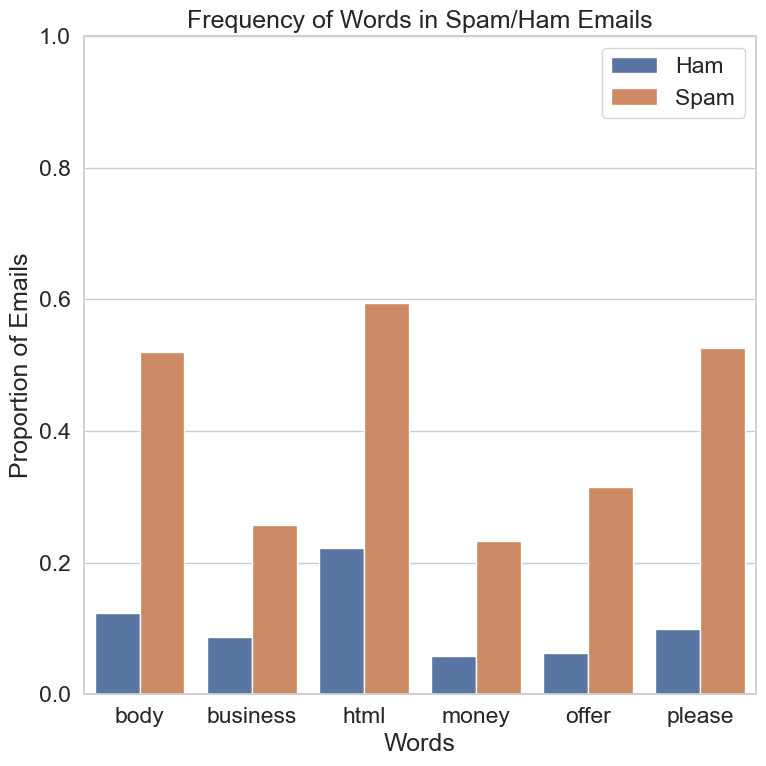

In [14]:
# We must do this in order to preserve the ordering of emails to labels for words_in_texts
train=train.reset_index(drop=True) 

some_words = ['body', 'html', 'please', 'money', 'business', 'offer']
Phi_train = words_in_texts(some_words, train['email'])

df = pd.DataFrame(data = Phi_train, columns = some_words)
df['label'] = train['spam']

plt.figure(figsize=(8,8))
sns.barplot(x = "variable", 
            y = "value", 
            hue = "label", 
            data = (df
                    .replace({'label': 
                                {0 : 'Ham', 
                                 1 : 'Spam'}})
                    .melt('label')
                    .groupby(['label', 'variable'])
                    .mean()
                    .reset_index()))

plt.ylim([0, 1])
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.legend(title = "")
plt.title("Frequency of Words in Spam/Ham Emails")
plt.tight_layout()
plt.show()

### Question 3

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

Create a *class conditional density plot* like the one above (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

<!--
BEGIN QUESTION
name: q3b
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

/var/folders/l0/h8hvnhwn7w117b13h1grbbqw0000gn/T/ipykernel_11873/2177718407.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/var/folders/l0/h8hvnhwn7w117b13h1grbbqw0000gn/T/ipykernel_11873/2177718407.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


Text(0, 0.5, 'Distribution')

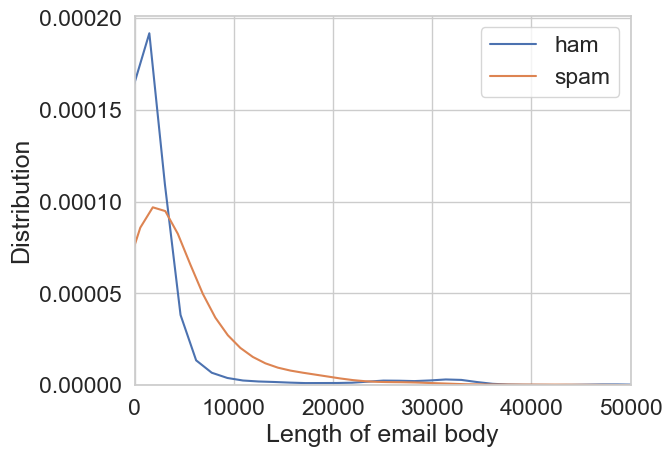

In [15]:
# BEGIN SOLUTION
plt.xlim([0, 50000])
sns.distplot(
    train[train['spam'] == 0]['email'].str.len(),
    label='ham',
    hist=False
)
sns.distplot(
    train[train['spam'] == 1]['email'].str.len(),
    label='spam',
    hist=False
)
plt.legend()
plt.xlabel('Length of email body')
plt.ylabel('Distribution')
# END SOLUTION

## Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

### Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

- `X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

- `Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your feature matrix (X) are correct, and that your features and labels are binary (i.e. consists of 0 and 1, no other values). It does not check that your function is correct; that was verified in a previous question.*

<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [16]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

# BEGIN YOUR CODE
# -----------------------
X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])
# -----------------------
# END YOUR CODE

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [17]:
assert X_train.shape == (7513, 5)
assert len(np.unique(X_train)) == 2
assert len(np.unique(Y_train)) == 2

print_passed('Q4: Passed all unit tests!')

Q4: Passed all unit tests!


### Question 5

Now we have matrices we can give to scikit-learn! 

- Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`.
- Then, output the accuracy of the model (on the training data) in the cell below. You should get an accuracy around 75\%.

<!--
BEGIN QUESTION
name: q5
points: 2
-->

In [18]:
from sklearn.linear_model import LogisticRegression

# BEGIN YOUR CODE
# -----------------------
model = LogisticRegression()
model.fit(X_train, Y_train)
training_accuracy = model.score(X_train, Y_train)
# -----------------------
# END YOUR CODE

print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [19]:
assert training_accuracy > 0.72
print_passed('Q5: Passed all unit tests!')

Q5: Passed all unit tests!


## Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as this might lead us to believe. First, we are evaluating accuracy on the training set, which may lead to a misleading accuracy measure, especially if we used the training set to identify discriminative features. In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The following image might help:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

### Question 6a

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Fill in the variables below (answers can be hard-coded):

<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [20]:
# BEGIN YOUR CODE
# -----------------------
zero_predictor_fp = 0
zero_predictor_fn = Y_train.sum()
# -----------------------
# END YOUR CODE

In [21]:
assert zero_predictor_fp + zero_predictor_fn == 1918
print_passed('Q6a: Passed all unit tests!')

Q6a: Passed all unit tests!


### Question 6b

What are the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Do NOT use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [22]:
# BEGIN YOUR CODE
# -----------------------
zero_predictor_acc = (Y_train == 0).mean()
zero_predictor_recall = 0
# -----------------------
# END YOUR CODE

In [23]:
assert np.isclose(zero_predictor_acc + zero_predictor_recall, 0.7447091707706642)
print_passed('Q6b: Passed all unit tests!')

Q6b: Passed all unit tests!


### Question 6c

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained in Question 5. **Note: Do NOT use any `sklearn` built-in functions.**

<!--
BEGIN QUESTION
name: q6d
points: 2
-->

In [25]:
# BEGIN YOUR CODE
# -----------------------
predict = pd.Series(model.predict(X_train))
logistic_predictor_precision = (
    (predict & Y_train).sum() / predict.sum()
)
logistic_predictor_recall = (predict & Y_train).sum() / Y_train.sum()
logistic_predictor_far = (
    (predict.sum() - (predict & Y_train).sum()) 
    / (Y_train.size - Y_train.sum())
)
# -----------------------
# END YOUR CODE

In [26]:
assert np.isclose(logistic_predictor_precision, 0.6422287390029325)
assert np.isclose(logistic_predictor_recall, 0.11418143899895725)
assert np.isclose(logistic_predictor_far, 0.021805183199285077)
print_passed('Q6c: Passed all unit tests!')

Q6c: Passed all unit tests!


### Question 6d

1. Our logistic regression classifier got 75.6% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
1. Given the word features we gave you above, name one reason this classifier is performing poorly. Hint: Think about how prevalent these words are in the email set.
1. Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

<!--
BEGIN QUESTION
name: q6f
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

Answer: 
1. `Not that much different`

2. `Given word set can likely be present in both spam and ham emails`

3. `I prefer logistic predictor because it has higher recall. I don't want to miss any spam mails`

# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the `validation` set.

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No random forests, k-nearest-neighbors, neural nets, etc.

### Question 7: EDA

In the cell below, show a visualization that you used to select features for your model. Include both

1. A plot showing something meaningful about the data that helped you during feature / model selection.
2. 2-3 sentences describing what you plotted and what its implications are for your features.

Feel free to create as many plots as you want in your process of feature selection, but select one for the response cell below.

**You should not just produce an identical visualization to question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, as long as it comes with thoughtful commentary. Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

Generate your visualization in the cell below and provide your description in a comment.

<!--
BEGIN QUESTION
name: q8
manual: True
format: image
points: 6
-->
<!-- EXPORT TO PDF format:image -->

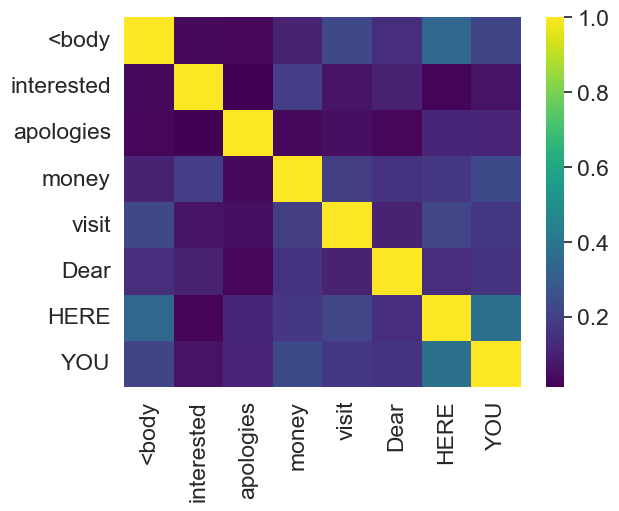

In [27]:
# Write your description (2-3 sentences) as a comment here:
# Implemented all the ideas above to improve my model
# Digged into the email data and found some words 
# that are more likely to appear in spam mails
# The heatmap below shows that there are no redundant words 
# that I used while conducting feature engineering
original_training_data = pd.read_csv(f'{workspace_path}/train.csv')
original_training_data.fillna("", inplace=True)
train, val = train_test_split(
    original_training_data, test_size=0.1, random_state=42)
train=train.reset_index(drop=True)
val=val.reset_index(drop=True)

some_words = ['<body', 'interested', 'apologies', 
	'money', 'visit', 'Dear', 'HERE', 'YOU']

def standardize(series):
	return (series - series.mean()) / series.std() 

def regex_ratio(regex, series):
	return (series.str.findall(regex).str.len() / 
		series.str.len().apply(lambda x: 1 if x == 0 else x))
	
def create_features(df):
	df['body_len'] = standardize(df['email'].str.len())
	df['body_words'] = standardize(
        df['email'].str.split().apply(len)
    )
	df['body_cap_ratio'] = regex_ratio(r'[A-Z]', df['email'])
	df['body_punct'] = (df['email'].str.count('!'))
	df['subj_len'] = standardize(df['subject'].str.len())
	df['subj_words'] = standardize(
        df['subject'].str.split().apply(len)
    )
	df['subj_cap_ratio'] = regex_ratio(r'[A-Z]', df['subject'])
	df['subj_punct'] = (df['subject'].str.count('!'))
	df['is_re_fwd'] = (df['subject'].str.contains('RE|Re|re|fwd'))
	df['html_ratio'] = regex_ratio(r'<[^>]+>', df['email'])
	
	Phi_df = words_in_texts(some_words, df['email'])
	
	return pd.concat(
		[df.loc[:, 'body_len':], 
		pd.DataFrame(data = Phi_df, columns = some_words)], 
		axis=1
	), df.loc[:, 'spam'].astype(int)

# Write the code to generate your visualization here:
Phi_df = words_in_texts(some_words, train['email'])
Phi_df_corr = pd.DataFrame(data=Phi_df, columns=some_words).corr()
sns.heatmap(Phi_df_corr, cmap='viridis')
plt.show()


### Question 8: Precision-Recall Curve

We can trade off between precision and recall. In most cases we won't be able to get both perfect precision (i.e. no false positives) and recall (i.e. no false negatives), so we have to compromise.

Recall that logistic regression calculates the probability that an example belongs to a certain class. 
* Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. 
* However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam. 

This is how we can trade off false positives and false negatives. The precision-recall curve shows this trade off for each possible cutoff probability. In the cell below, [plot a precision-recall curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#plot-the-precision-recall-curve) for your final classifier.

<!--
BEGIN QUESTION
name: q9
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

For train set:  0.8843338213762811
For validation set:  0.8802395209580839


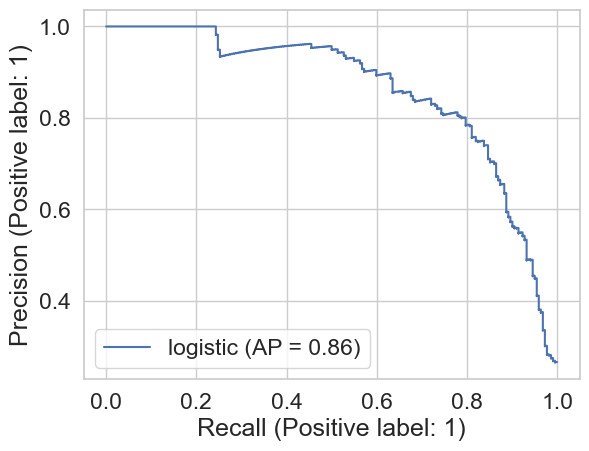

In [28]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

# BEGIN YOUR CODE
# -----------------------

my_model = LogisticRegression(max_iter=1000)
my_X_train, Y_train = create_features(train)

my_model.fit(my_X_train, Y_train)

my_training_accuracy = (
	(my_model.predict_proba(my_X_train)[:, 1] >= 0.5).astype(int)
    == Y_train
).mean()
print("For train set: ", my_training_accuracy)

my_X_val, Y_val = create_features(val)
my_val_acc = (
	(my_model.predict_proba(my_X_val)[:, 1] >= 0.5).astype(int)
    == Y_val
).mean()
print("For validation set: ", my_val_acc)

display = PrecisionRecallDisplay.from_estimator(
    my_model, my_X_val, Y_val, name="logistic"
)

# -----------------------
# END YOUR CODE

### Congratulations! You have completed HW 3.

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.,

**Please save before submitting!**

Please generate pdf as follows and submit it to Gradescope.

**File > Print Preview > Print > Save as pdf**

<!-- EXPECT 9 EXPORTED QUESTIONS -->